In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
from itertools import product, combinations

from paths import *
from ssd_paths import *
from misc_recorder import *

In [2]:
hyper_dir = model_save_
ts = "0905160507"
plot_save_place = "./plots/"

In [3]:
class ResReader: 
    def __init__(self, dir, runtype="ff", cv="full"):
        self.dir = dir
        self.runtype = runtype
        self.cv = cv
    
    def read(self):
        read_dir = os.path.join(self.dir, self.cv, self.runtype)
        train = ListRecorder(os.path.join(read_dir, 'train.acc'))
        valid = ListRecorder(os.path.join(read_dir, f'valid.acc'))
        fullvalid = ListRecorder(os.path.join(read_dir, f'full_valid.acc'))
        train.read()
        valid.read()
        fullvalid.read()
        return train.get(), valid.get(), fullvalid.get()

In [4]:
def draw(reses, y_label="Accuracy", title=""): 
    data = list(reses.values())

    # Function to calculate mean and 95% CI
    def mean_confidence_interval(data, confidence=0.95):
        n = len(data)
        mean = np.mean(data)
        sem = stats.sem(data)
        margin = sem * stats.t.ppf((1 + confidence) / 2., n-1)
        return mean, margin

    # Calculate means and CIs
    means = [mean_confidence_interval(group)[0] for group in data]
    cis = [mean_confidence_interval(group)[1] for group in data]

    # Plotting
    fig, ax = plt.subplots()
    x_pos = np.arange(len(data))
    ax.bar(x_pos, means, yerr=cis, align='center', alpha=0.7, ecolor='black', capsize=10)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(reses.keys())
    ax.set_title(title)
    ax.yaxis.grid(True)

    # Show the plot
    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(plot_save_place, f"{ts}-{title}.png"))

In [5]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "epoch"])

for model_type, runtype, cv in list(product(["reslin", "lstm", "large"], ["lf", "hf"], ["full"])):
    for pre in [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]: 
        for run_case in range(1, 21): 
            dir = os.path.join(hyper_dir, f"H21-{ts}-{run_case}", f"{model_type}-{pre}-{120-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            look_at = 2
            resdict = {
                "run": run_case, 
                "epoch": list(range(120)), 
                "preepoch_cond": pre, 
                "model_cond": model_type, 
                "train_filter_cond": runtype, 
                "valid_phone_cond": cv, 
                "train_acc": res[0], 
                "target_valid_acc": res[1], 
                "full_valid_acc": res[2]
            }
            # add before training data
            special_recs_recorder = DictRecorder(os.path.join(dir, cv, runtype, "special.hst"))
            special_recs_recorder.read()
            special_recs = special_recs_recorder.record
            pre_resdict = {
                "run": run_case, 
                "epoch": [-1], 
                "preepoch_cond": pre, 
                "model_cond": model_type, 
                "train_filter_cond": runtype, 
                "valid_phone_cond": cv, 
                "train_acc": [special_recs["notrain-target-acc"]], 
                "target_valid_acc": [special_recs["notrain-target-acc"]], 
                "full_valid_acc": [special_recs["notrain-full-acc"]]
            }
            total_df = pd.concat([total_df, pd.DataFrame(pre_resdict), pd.DataFrame(resdict)], axis=0)
    # draw(reses, "Accuracy", f"Increase in Accuracy {model_type}-{runtype}-{cv}")

total_df.to_csv(os.path.join(hyper_dir, f"accstage-{ts}.csv"), index=False)

In [6]:
total_df

,run,preepoch_cond,model_cond,train_filter_cond,valid_phone_cond,epoch,train_acc,target_valid_acc,full_valid_acc
0,1,0,reslin,lf,full,-1,0.054071,0.054071,0.021442
0,1,0,reslin,lf,full,0,0.239758,0.325357,0.325357
1,1,0,reslin,lf,full,1,0.311745,0.342449,0.342449
2,1,0,reslin,lf,full,2,0.342041,0.361715,0.361715
3,1,0,reslin,lf,full,3,0.361944,0.387508,0.387508
...,...,...,...,...,...,...,...,...,...
115,20,60,large,hf,full,115,0.745195,0.612181,0.612181
116,20,60,large,hf,full,116,0.749087,0.619329,0.619329
117,20,60,large,hf,full,117,0.751254,0.619950,0.619950
118,20,60,large,hf,full,118,0.751936,0.614046,0.614046


: 

# Plot

/tmp/ipykernel_804116/1323412784.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)


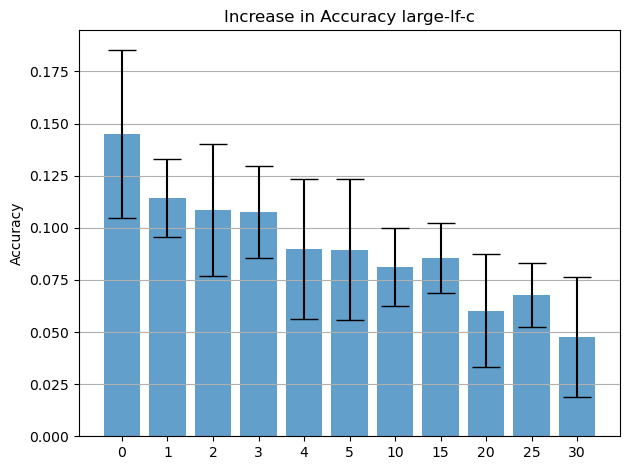

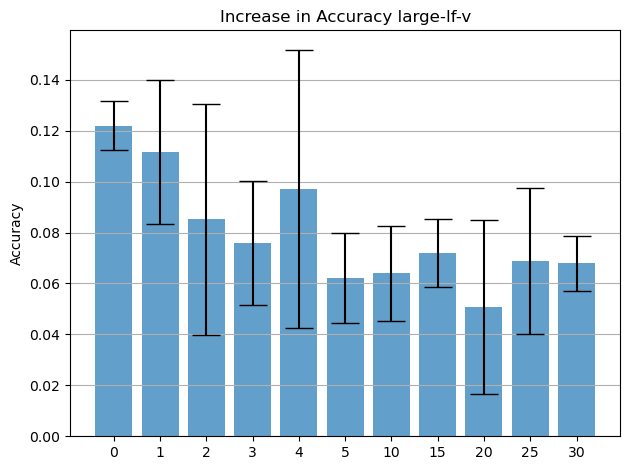

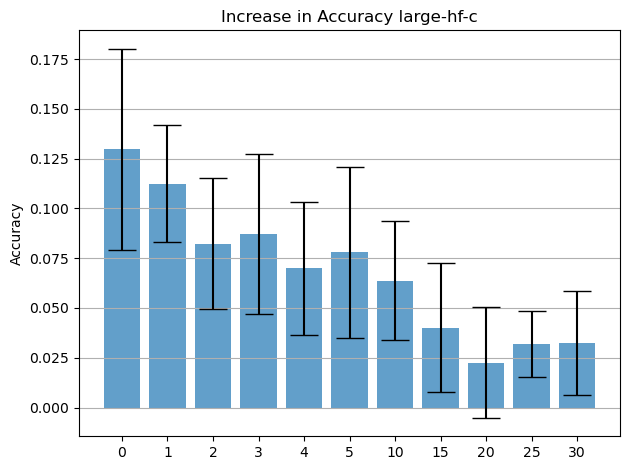

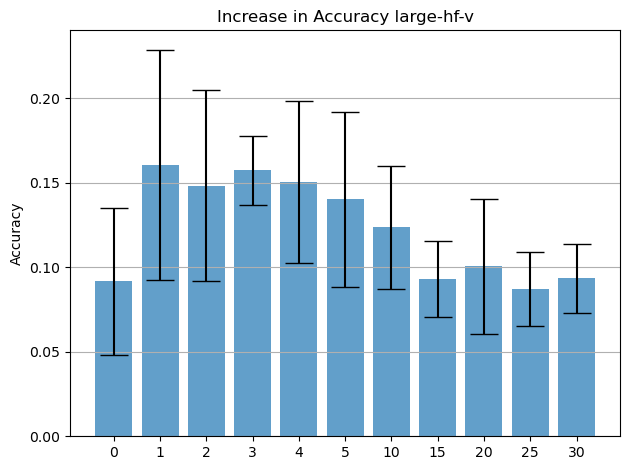

In [9]:
total_df = pd.DataFrame(columns=["run", "preepoch_cond", "model_cond", "train_filter_cond", "valid_phone_cond", "acc_inc"])

for model_type, runtype, cv in list(product(["large"], ["lf", "hf"], ["c", "v"])): # "reslin", "lstm", 
    reses = {}
    for pre in [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30]: 
        for run_case in range(1, 6): 
            dir = os.path.join(hyper_dir, f"H21-{ts}-{run_case}", f"{model_type}-{pre}-{70-pre}")
            res = ResReader(dir, runtype=runtype, cv=cv).read()
            special_recs_recorder = DictRecorder(os.path.join(dir, cv, runtype, "special.hst"))
            special_recs_recorder.read()
            special_recs = special_recs_recorder.record
            # val = np.mean([x - y for x, y in zip(res[1], res[2])][pre - 1])
            look_at = 1
            jump = 1
            # val = res[look_at][1] - special_recs["notrain-full-acc"]
            if pre == 0: 
                # val = res[look_at][pre + jump] - res[look_at][pre]
                val = res[look_at][pre + jump - 1] - special_recs["notrain-full-acc"]
            else: 
                val = res[look_at][pre + jump - 1] - res[look_at][pre - 1]
            # val = np.mean(res[0][35:40]) - np.mean(res[2][35:40])
            if f"{pre}" in reses.keys(): 
                reses[f"{pre}"].append(val)
            else: 
                reses[f"{pre}"] = [val]
        resdict = {
            "run": list(range(1, 6)), 
            "preepoch_cond": pre, 
            "model_cond": model_type, 
            "train_filter_cond": runtype, 
            "valid_phone_cond": cv, 
            "acc_inc": reses[f"{pre}"]
        }
        total_df = pd.concat([total_df, pd.DataFrame(resdict)], axis=0)
    draw(reses, "Accuracy", f"Increase in Accuracy {model_type}-{runtype}-{cv}")

# total_df.to_csv(os.path.join(hyper_dir, f"accinc-{ts}.csv"), index=False)